In [2]:
import os
import sys
import random
import json
import collections

import pandas as pd
import numpy as np
import scipy
import statsmodels
from tqdm import trange, tqdm_notebook as tqdm

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


pd.options.display.max_columns = 999

sns.set()
plt.rcParams["figure.figsize"] = (10,7)

In [3]:
os.getcwd()

'/home/boris/study/UT study/ACM Sigmod/sigmod/notebooks'

# Labels

In [4]:
MED_LABELS_PATH = '../data/raw/sigmod_medium_labelled_dataset.csv'
LG_LABELS_PATH = '../data/raw/sigmod_large_labelled_dataset.csv'

In [5]:
med_labels_df = pd.read_csv(MED_LABELS_PATH)
med_labels_df.head()

,left_spec_id,right_spec_id,label
0,www.garricks.com.au//31,www.ebay.com//53278,1
1,www.ebay.com//58782,www.ebay.com//24817,0
2,www.ebay.com//58782,www.ebay.com//43019,0
3,www.ebay.com//42055,www.ebay.com//54403,0
4,www.ebay.com//44280,buy.net//6145,0


In [6]:
lg_labels_df = pd.read_csv(LG_LABELS_PATH)
lg_labels_df.head()

,left_spec_id,right_spec_id,label
0,www.ebay.com//53278,www.garricks.com.au//31,1
1,www.ebay.com//24817,www.ebay.com//58782,0
2,www.ebay.com//43019,www.ebay.com//58782,0
3,www.ebay.com//42055,www.ebay.com//54403,0
4,buy.net//6145,www.ebay.com//44280,0


In [7]:
med_labels_df.shape, lg_labels_df.shape

((46665, 3), (297651, 3))

In [8]:
med_labels_df['left_site'] = med_labels_df['left_spec_id'].apply(lambda x: x.split('//')[0])
med_labels_df['right_site'] = med_labels_df['right_spec_id'].apply(lambda x: x.split('//')[0])

med_labels_df['left_file_id'] = med_labels_df['left_spec_id'].apply(lambda x: x.split('//')[1])
med_labels_df['right_file_id'] = med_labels_df['right_spec_id'].apply(lambda x: x.split('//')[1])

In [9]:
lg_labels_df['left_site'] = lg_labels_df['left_spec_id'].apply(lambda x: x.split('//')[0])
lg_labels_df['right_site'] = lg_labels_df['right_spec_id'].apply(lambda x: x.split('//')[0])

lg_labels_df['left_file_id'] = lg_labels_df['left_spec_id'].apply(lambda x: x.split('//')[1])
lg_labels_df['right_file_id'] = lg_labels_df['right_spec_id'].apply(lambda x: x.split('//')[1])

In [10]:
med_labels_df.head()

,left_spec_id,right_spec_id,label,left_site,right_site,left_file_id,right_file_id
0,www.garricks.com.au//31,www.ebay.com//53278,1,www.garricks.com.au,www.ebay.com,31,53278
1,www.ebay.com//58782,www.ebay.com//24817,0,www.ebay.com,www.ebay.com,58782,24817
2,www.ebay.com//58782,www.ebay.com//43019,0,www.ebay.com,www.ebay.com,58782,43019
3,www.ebay.com//42055,www.ebay.com//54403,0,www.ebay.com,www.ebay.com,42055,54403
4,www.ebay.com//44280,buy.net//6145,0,www.ebay.com,buy.net,44280,6145


In [11]:
med_labels_df_dup = pd.DataFrame(med_labels_df[med_labels_df.label==1])
med_labels_df_dup.head()

,left_spec_id,right_spec_id,label,left_site,right_site,left_file_id,right_file_id
0,www.garricks.com.au//31,www.ebay.com//53278,1,www.garricks.com.au,www.ebay.com,31,53278
18,www.ebay.com//46524,www.ebay.com//44635,1,www.ebay.com,www.ebay.com,46524,44635
19,www.shopbot.com.au//331,www.mypriceindia.com//155,1,www.shopbot.com.au,www.mypriceindia.com,331,155
60,www.ebay.com//55080,www.ebay.com//47191,1,www.ebay.com,www.ebay.com,55080,47191
73,www.ebay.com//54040,www.ebay.com//54457,1,www.ebay.com,www.ebay.com,54040,54457


In [12]:
lg_labels_df_dup = pd.DataFrame(lg_labels_df[lg_labels_df.label==1])
lg_labels_df_dup.head()

,left_spec_id,right_spec_id,label,left_site,right_site,left_file_id,right_file_id
0,www.ebay.com//53278,www.garricks.com.au//31,1,www.ebay.com,www.garricks.com.au,53278,31
18,www.ebay.com//44635,www.ebay.com//46524,1,www.ebay.com,www.ebay.com,44635,46524
19,www.mypriceindia.com//155,www.shopbot.com.au//331,1,www.mypriceindia.com,www.shopbot.com.au,155,331
60,www.ebay.com//47191,www.ebay.com//55080,1,www.ebay.com,www.ebay.com,47191,55080
73,www.ebay.com//54040,www.ebay.com//54457,1,www.ebay.com,www.ebay.com,54040,54457


In [13]:
med_labels_df_dup.shape, lg_labels_df_dup.shape

((3582, 7), (44039, 7))

### Classes are very imbalanced

In [14]:
med_labels_df_dup[(med_labels_df_dup.right_spec_id=='www.garricks.com.au//31') & (med_labels_df_dup.left_spec_id=='www.ebay.com//53278')]

,left_spec_id,right_spec_id,label,left_site,right_site,left_file_id,right_file_id


Each duplicate is only included once:

In [15]:
med_labels_df_dup['site_pair'] = med_labels_df_dup.left_site + ', '+med_labels_df_dup.right_site
lg_labels_df_dup['site_pair'] = lg_labels_df_dup.left_site + ', '+lg_labels_df_dup.right_site

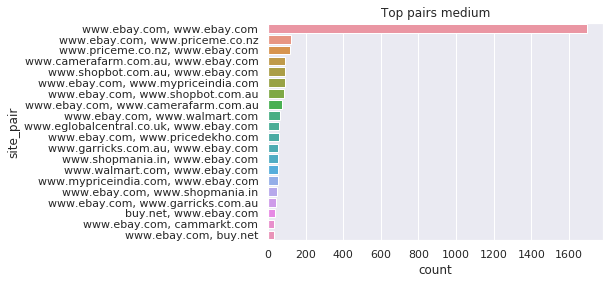

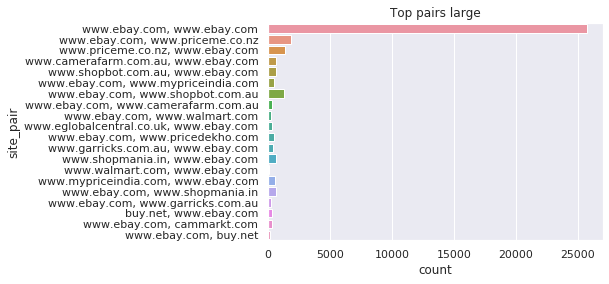

In [16]:
top_pairs = med_labels_df_dup.site_pair.value_counts().sort_values(ascending=False).head(20)
plot_df = med_labels_df_dup[med_labels_df_dup.site_pair.isin(top_pairs.index.tolist())]

plt.figure()
plt.title('Top pairs medium')
sns.countplot(y='site_pair', data=plot_df, order=top_pairs.index.tolist())
plt.show()

plot_df = lg_labels_df_dup[lg_labels_df_dup.site_pair.isin(top_pairs.index.tolist())]

plt.figure()
plt.title('Top pairs large')
sns.countplot(y='site_pair', data=plot_df, order=top_pairs.index.tolist())
plt.show()

### It's most important to predict ebay <> ebay duplicates only

In [17]:
med_specs = set(med_labels_df.left_spec_id.unique()).union(set(med_labels_df.right_spec_id.unique()))
print(len(med_specs), 'unique specs in medium')

306 unique specs in medium


In [18]:
lg_specs = set(lg_labels_df.left_spec_id.unique()).union(set(lg_labels_df.right_spec_id.unique()))
print(len(lg_specs), 'unique specs in large')

908 unique specs in large


In [19]:
print('Intersection:', len(lg_specs.intersection(med_specs)))

Intersection: 306


In [20]:
med_labels_df.head()

,left_spec_id,right_spec_id,label,left_site,right_site,left_file_id,right_file_id
0,www.garricks.com.au//31,www.ebay.com//53278,1,www.garricks.com.au,www.ebay.com,31,53278
1,www.ebay.com//58782,www.ebay.com//24817,0,www.ebay.com,www.ebay.com,58782,24817
2,www.ebay.com//58782,www.ebay.com//43019,0,www.ebay.com,www.ebay.com,58782,43019
3,www.ebay.com//42055,www.ebay.com//54403,0,www.ebay.com,www.ebay.com,42055,54403
4,www.ebay.com//44280,buy.net//6145,0,www.ebay.com,buy.net,44280,6145


In [21]:
lg_labels_df.head()

,left_spec_id,right_spec_id,label,left_site,right_site,left_file_id,right_file_id
0,www.ebay.com//53278,www.garricks.com.au//31,1,www.ebay.com,www.garricks.com.au,53278,31
1,www.ebay.com//24817,www.ebay.com//58782,0,www.ebay.com,www.ebay.com,24817,58782
2,www.ebay.com//43019,www.ebay.com//58782,0,www.ebay.com,www.ebay.com,43019,58782
3,www.ebay.com//42055,www.ebay.com//54403,0,www.ebay.com,www.ebay.com,42055,54403
4,buy.net//6145,www.ebay.com//44280,0,buy.net,www.ebay.com,6145,44280


In [22]:
med_labels_df.shape

(46665, 7)

In [23]:
overlap = lg_labels_df[lg_labels_df.isin(med_labels_df)].dropna()
overlap.shape

(25186, 7)

In [24]:
med_labels_df.sort_values(by=['left_spec_id', 'right_spec_id']).head()

,left_spec_id,right_spec_id,label,left_site,right_site,left_file_id,right_file_id
38956,buy.net//5641,buy.net//5698,0,buy.net,buy.net,5641,5698
39281,buy.net//5641,buy.net//5791,0,buy.net,buy.net,5641,5791
33358,buy.net//5641,buy.net//5946,0,buy.net,buy.net,5641,5946
40657,buy.net//5641,buy.net//6145,0,buy.net,buy.net,5641,6145
9198,buy.net//5641,cammarkt.com//203,0,buy.net,cammarkt.com,5641,203


In [25]:
overlap.sort_values(by=['left_spec_id', 'right_spec_id']).head()

,left_spec_id,right_spec_id,label,left_site,right_site,left_file_id,right_file_id
38956,buy.net//5641,buy.net//5698,0.0,buy.net,buy.net,5641,5698
39281,buy.net//5641,buy.net//5791,0.0,buy.net,buy.net,5641,5791
33358,buy.net//5641,buy.net//5946,0.0,buy.net,buy.net,5641,5946
40657,buy.net//5641,buy.net//6145,0.0,buy.net,buy.net,5641,6145
9198,buy.net//5641,cammarkt.com//203,0.0,buy.net,cammarkt.com,5641,203


## Large and medium datasets do overlap!

In [26]:
print('If we removed fully overlapping rows')
lg_labels_df[~lg_labels_df.isin(med_labels_df)].dropna().shape

If we removed fully overlapping rows


(250986, 7)

## Should we remove partially overlapping rows?
I think we shouldn't.
Partially overlapping rows provide zero-labelled rows for the classifier, so they do have some new information, so keep them.

In [27]:
specs_in_large = set(lg_labels_df.left_spec_id).union(lg_labels_df.right_spec_id)
specs_in_med = set(med_labels_df.left_spec_id).union(med_labels_df.right_spec_id)

print('Med', len(specs_in_med), 'LG', len(specs_in_large), 'intersection', len(specs_in_large.intersection(specs_in_med)))

Med 306 LG 908 intersection 306


In [28]:
lg_labels_df[lg_labels_df.left_spec_id == 'www.ebay.com//53278'].head()

,left_spec_id,right_spec_id,label,left_site,right_site,left_file_id,right_file_id
0,www.ebay.com//53278,www.garricks.com.au//31,1,www.ebay.com,www.garricks.com.au,53278,31
591,www.ebay.com//53278,www.priceme.co.nz//2246,0,www.ebay.com,www.priceme.co.nz,53278,2246
597,www.ebay.com//53278,www.shopbot.com.au//1376,0,www.ebay.com,www.shopbot.com.au,53278,1376
609,www.ebay.com//53278,www.flipkart.com//2193,0,www.ebay.com,www.flipkart.com,53278,2193
628,www.ebay.com//53278,www.ebay.com//58781,0,www.ebay.com,www.ebay.com,53278,58781


In [29]:
med_labels_df[med_labels_df.left_spec_id == 'www.ebay.com//53278'].head()

,left_spec_id,right_spec_id,label,left_site,right_site,left_file_id,right_file_id
591,www.ebay.com//53278,www.priceme.co.nz//2246,0,www.ebay.com,www.priceme.co.nz,53278,2246
597,www.ebay.com//53278,www.shopbot.com.au//1376,0,www.ebay.com,www.shopbot.com.au,53278,1376
609,www.ebay.com//53278,www.flipkart.com//2193,0,www.ebay.com,www.flipkart.com,53278,2193
628,www.ebay.com//53278,www.ebay.com//58781,0,www.ebay.com,www.ebay.com,53278,58781
711,www.ebay.com//53278,www.ebay.com//43741,0,www.ebay.com,www.ebay.com,53278,43741


# Specs

In [30]:
SPECS_PATH = '../data/raw/2013_camera_specs/'

In [31]:
site_folders = os.listdir(SPECS_PATH)
site_folders

['www.ebay.com',
 'www.price-hunt.com',
 'www.mypriceindia.com',
 'www.pcconnection.com',
 'www.camerafarm.com.au',
 'www.priceme.co.nz',
 'www.pricedekho.com',
 'www.shopbot.com.au',
 'www.walmart.com',
 'www.wexphotographic.com',
 'www.ilgs.net',
 'www.canon-europe.com',
 'www.buzzillions.com',
 'www.ukdigitalcameras.co.uk',
 'www.cambuy.com.au',
 'buy.net',
 'www.garricks.com.au',
 'www.shopmania.in',
 'www.flipkart.com',
 'www.henrys.com',
 'www.alibaba.com',
 'www.gosale.com',
 'cammarkt.com',
 'www.eglobalcentral.co.uk']

In [32]:
site_spec_count = []
for site in site_folders:
    site_spec_count.append((site, len(os.listdir(os.path.join(SPECS_PATH, site)))))
site_spec_count = sorted(site_spec_count, key=lambda x: -x[1])
site_spec_count

[('www.ebay.com', 14274),
 ('www.alibaba.com', 7972),
 ('www.gosale.com', 1002),
 ('www.buzzillions.com', 832),
 ('www.priceme.co.nz', 740),
 ('www.shopmania.in', 630),
 ('www.eglobalcentral.co.uk', 571),
 ('www.shopbot.com.au', 516),
 ('www.pricedekho.com', 366),
 ('buy.net', 358),
 ('www.mypriceindia.com', 347),
 ('www.price-hunt.com', 327),
 ('www.pcconnection.com', 211),
 ('cammarkt.com', 198),
 ('www.walmart.com', 195),
 ('www.henrys.com', 181),
 ('www.canon-europe.com', 164),
 ('www.flipkart.com', 157),
 ('www.wexphotographic.com', 147),
 ('www.garricks.com.au', 130),
 ('www.ukdigitalcameras.co.uk', 129),
 ('www.camerafarm.com.au', 120),
 ('www.cambuy.com.au', 118),
 ('www.ilgs.net', 102)]

### Weird: a lot of specs from alibaba, but alibaba is not even in top by duplicates

#### Pick two random ebay specs

In [33]:
def read_json(path):
    with open(path, 'r') as f:
        return json.load(f)
    
def pprint_json(json_):
    print(json.dumps(json_, indent=4, sort_keys=True))

In [34]:
ebay_specs = os.path.join(SPECS_PATH, 'www.ebay.com')

In [35]:
spec1_path = os.path.join(ebay_specs, random.choice(os.listdir(ebay_specs)))
spec2_path = os.path.join(ebay_specs, random.choice(os.listdir(ebay_specs)))
print(spec1_path)
pprint_json(read_json(spec1_path))
print()
print(spec2_path)
pprint_json(read_json(spec2_path))

../data/raw/2013_camera_specs/www.ebay.com/47445.json
{
    "<page title>": "Canon EOS 40D 10 1 MP Digital SLR Camera w Accessories and Original Box | eBay",
    "brand": "Canon",
    "bundled items": "remote, battery charger, card case, USB card reader, original box, Extra Battery, Memory Card, Strap (Neck or Wrist)",
    "megapixels": "10.1 MP",
    "model": "40D",
    "mpn": "1901B004",
    "screen size": "3\"",
    "type": "Digital SLR",
    "upc": "689076803281"
}

../data/raw/2013_camera_specs/www.ebay.com/56743.json
{
    "<page title>": "Sony Mavica MVC FD73 0 4 MP Digital Camera with Accessories and Bag Bundle | eBay",
    "brand": "Sony",
    "bundled items": "CAMERA ONLY",
    "country/region of manufacture": "Japan",
    "manufacturer warranty": "No",
    "megapixels": "0.4 MP",
    "model": "MVC-FD73",
    "mpn": "MVC-FD73",
    "optical zoom": "10x",
    "screen size": "2.5\"",
    "type": "Point & Shoot",
    "upc": "0027242552623"
}


### Pick two duplicate specs

In [36]:
ebay_dups_df = med_labels_df_dup[(med_labels_df_dup.left_site == 'www.ebay.com') 
                             & (med_labels_df_dup.right_site == 'www.ebay.com')]
ebay_dups_df.head()

,left_spec_id,right_spec_id,label,left_site,right_site,left_file_id,right_file_id,site_pair
18,www.ebay.com//46524,www.ebay.com//44635,1,www.ebay.com,www.ebay.com,46524,44635,"www.ebay.com, www.ebay.com"
60,www.ebay.com//55080,www.ebay.com//47191,1,www.ebay.com,www.ebay.com,55080,47191,"www.ebay.com, www.ebay.com"
73,www.ebay.com//54040,www.ebay.com//54457,1,www.ebay.com,www.ebay.com,54040,54457,"www.ebay.com, www.ebay.com"
87,www.ebay.com//56845,www.ebay.com//47729,1,www.ebay.com,www.ebay.com,56845,47729,"www.ebay.com, www.ebay.com"
167,www.ebay.com//42173,www.ebay.com//54482,1,www.ebay.com,www.ebay.com,42173,54482,"www.ebay.com, www.ebay.com"


In [37]:
random_row = ebay_dups_df.sample(1)
left_file_id = random_row.left_file_id.values[0]
right_file_id = random_row.right_file_id.values[0]

left_path = os.path.join(ebay_specs, left_file_id+'.json')
right_path = os.path.join(ebay_specs, right_file_id+'.json')

print(left_path)
pprint_json(read_json(left_path))
print()
print(right_path)
pprint_json(read_json(right_path))

../data/raw/2013_camera_specs/www.ebay.com/56845.json
{
    "<page title>": "Nikon D3200 DSLR Camera Import 18 55 VR w A and Tele 7 Lens 24GB Bundle | eBay",
    "brand": "Nikon",
    "bundled items": "Flash Diffusers, Starter DVD, Macro Lens, Cap Keeper, Case or Bag, Lens, Lens Cleaning Kit, Lens Filter, Memory Card, Memory Reader, Strap (Neck or Wrist), Tripod",
    "condition": "New: A brand-new, unused, unopened, undamaged item in its original packaging (where packaging is\napplicable). Packaging should be the same as what is found in a retail store, unless the item is handmade or was packaged by the manufacturer in non-retail packaging, such as an unprinted box or plastic bag. See the seller's listing for full details.\nSee all condition definitions- opens in a new window or tab\n... Read moreabout the condition",
    "megapixels": "24.2 MP",
    "model": "D3200",
    "mpn": "254929793",
    "optical zoom": "3x",
    "screen size": "3\"",
    "type": "Digital SLR"
}

../data/raw/2

Observations:
* brand is included in page title
* can lowercase whole string without any changes
* includes unique product code at the end
* "| eBay" can be cut off
* big intersection of words
* fields on page are mostly included in page title, redudant

## Lets pick two duplicates from different sites

In [38]:
random_row = med_labels_df_dup.sample(1)
left_site = random_row.left_site.values[0]
left_file_id = random_row.left_file_id.values[0]
right_site = random_row.right_site.values[0]
right_file_id = random_row.right_file_id.values[0]

left_path = os.path.join(SPECS_PATH, left_site, left_file_id+'.json')
right_path = os.path.join(SPECS_PATH, right_site, right_file_id+'.json')

print(left_path)
pprint_json(read_json(left_path))
print()
print(right_path)
pprint_json(read_json(right_path))

../data/raw/2013_camera_specs/www.ebay.com/60484.json
{
    "<page title>": "Nikon D3200 Digital SLR Camera w 18 55mm Lens 32GB Complete Kit | eBay",
    "angle of view": "76\u00c2\u00b0 - 28\u00c2\u00b0",
    "aperture": "Maximum: f/3.5 - 5.6Minimum: f/22 - 36",
    "autofocus": "Yes",
    "autofocus points": "11",
    "brand": "Nikon",
    "builtin flash": "Yes: Auto, Auto/Red-eye Reduction, Off, Second-curtain Sync, Slow Sync, Slow Sync./Red-eye Reduction",
    "bundled items": "Case or Bag, Flash, Lens, Lens Cleaning Kit, Memory Card, Memory Reader, Tripod",
    "condition": "New: A brand-new, unused, unopened, undamaged item in its original packaging (where packaging is\napplicable). Packaging should be the same as what is found in a retail store, unless the item is handmade or was packaged by the manufacturer in non-retail packaging, such as an unprinted box or plastic bag. See the seller's listing for full details.\nSee all condition definitions- opens in a new window or tab\n..

Observations:
* page title has big overlap on brand, model, megapixels
* little-to-no overlap on other fields, most fields are redudant for indentifying a duplicate

Maybe brand can be extracted and simply label-encoded

## Let's see the count of filled fields in ebay

In [39]:
def site_field_counts(site):
    field_counts = collections.Counter()

    for fname in os.listdir(os.path.join(SPECS_PATH, site)):
        path = os.path.join(SPECS_PATH, site, fname)
        parsed = read_json(path)

        for k, v in parsed.items():
            field_counts[k] += 1
    
    field_counts_df = pd.DataFrame(field_counts.items(), columns=['field', 'count']).sort_values(by='count', ascending=False)
    return field_counts_df

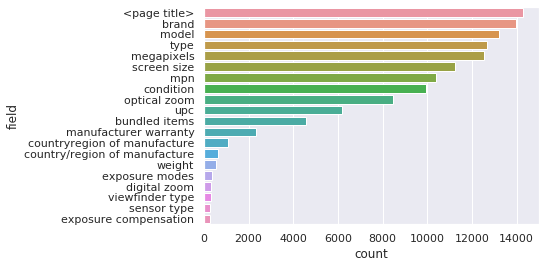

In [40]:
sns.barplot(x='count', y='field', data=site_field_counts('www.ebay.com').head(20))

## Some fields are just errors in spelling, can be easily fixed. We definitely can take only fields that have >=1000 filled values and drop the rest

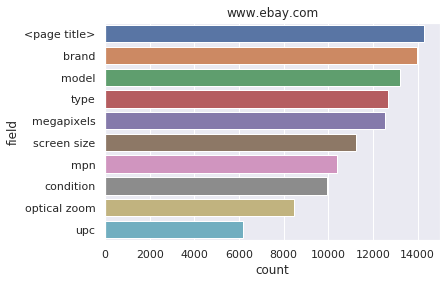

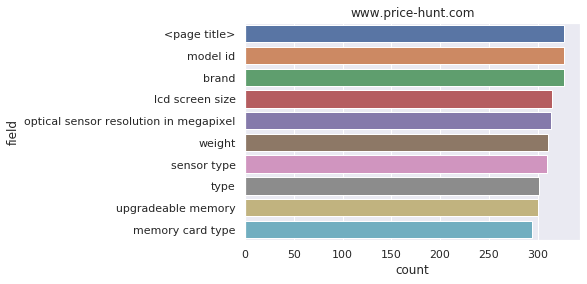

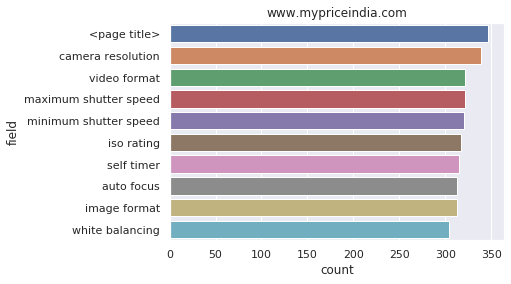

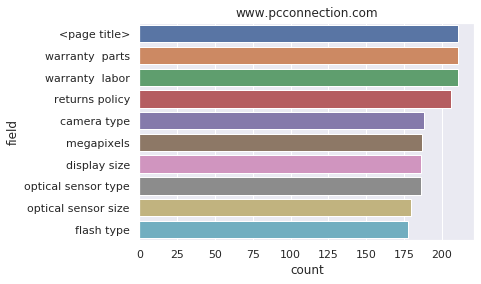

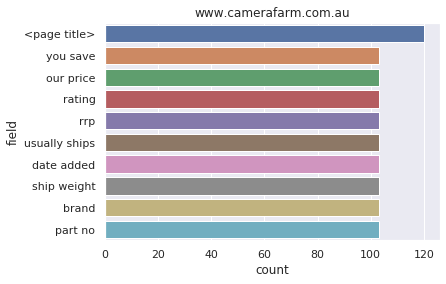

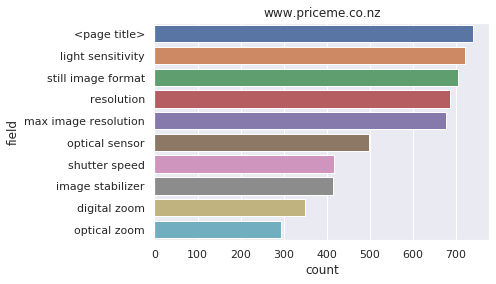

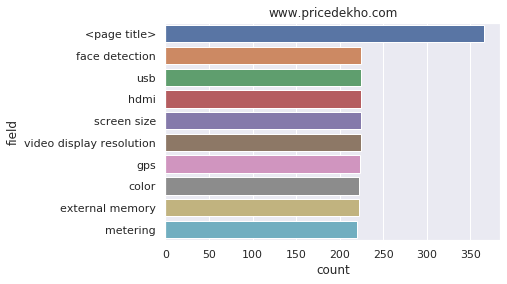

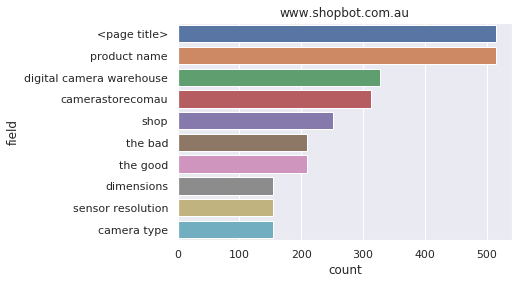

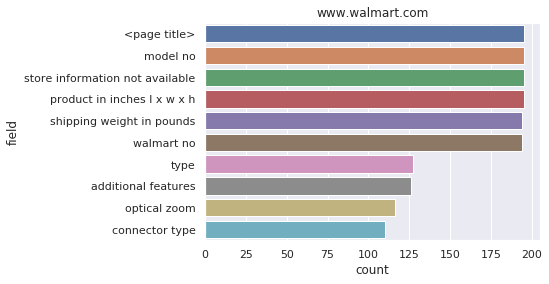

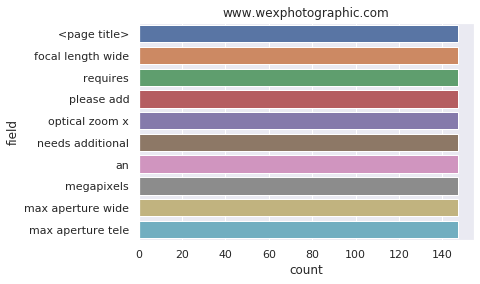

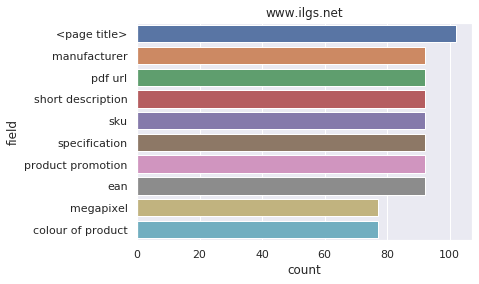

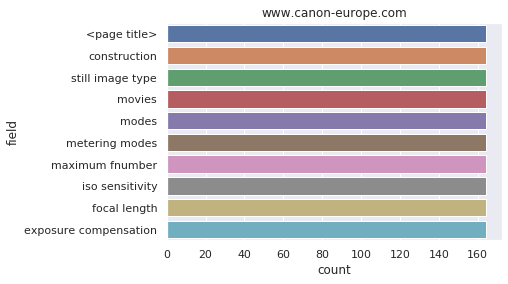

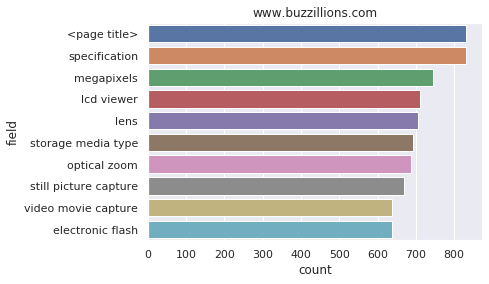

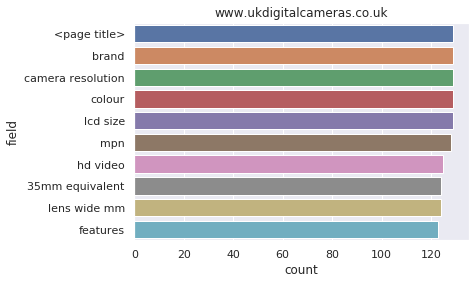

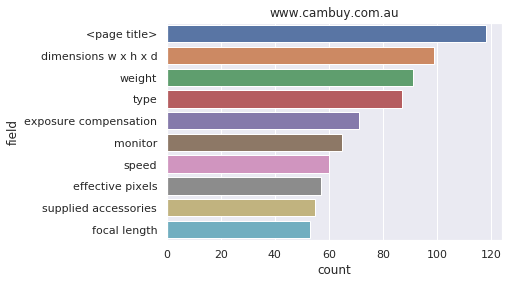

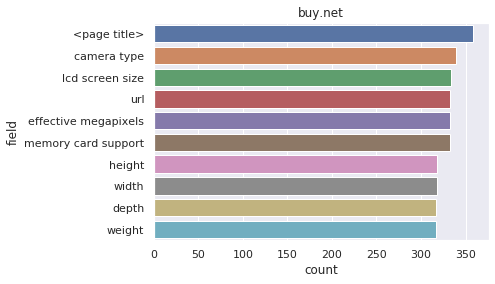

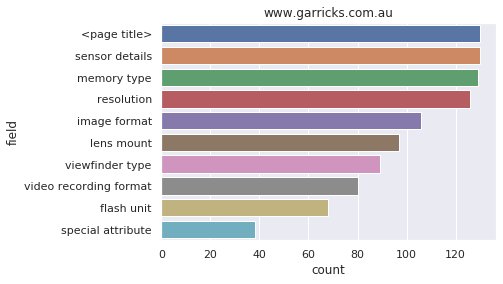

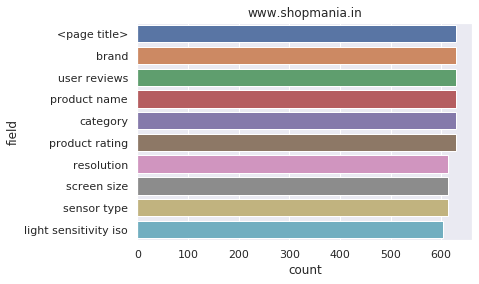

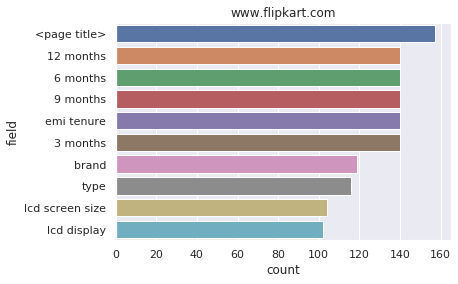

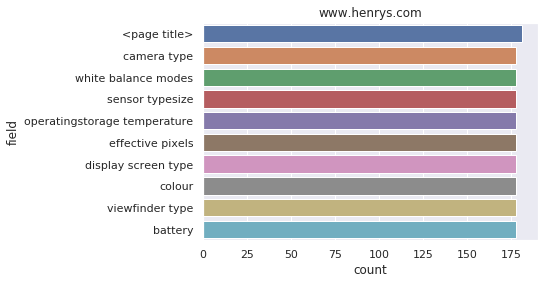

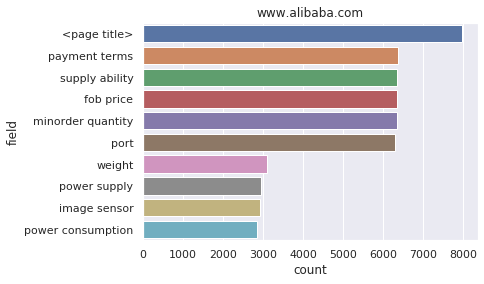

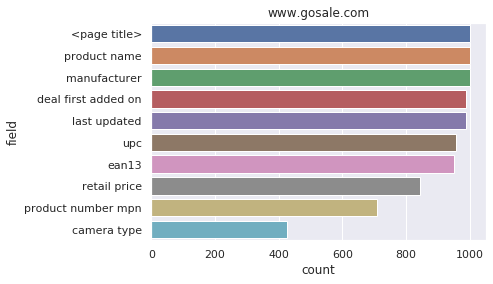

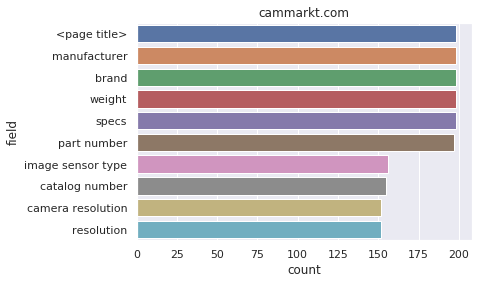

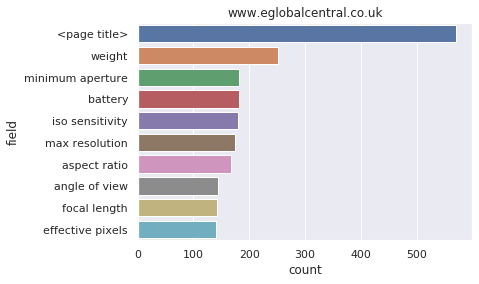

In [41]:
for site in site_folders:
    plt.figure()
    sns.barplot(x='count', y='field', data=site_field_counts(site).head(10))
    plt.title(site)
    plt.show()

## Different sites have really different field sets

# Wordcloud of page titles

## Extract page titles and all text

In [42]:
def extract_text(obj):
    results = []
    def _extract(obj, strings=None):
        strings = strings or []
        if isinstance(obj, str):
            strings.append(obj)
            return strings
        elif isinstance(obj, dict):
            for key in obj.keys():
                addition = _extract(obj[key])
                strings += addition
            return strings
        elif isinstance(obj, list):
            for item in obj:
                strings += _extract(item)
                return strings
        else:
            strings.append(str(obj))
            return strings
        
    results = _extract(obj, [])
    return results
extract_text(parsed)

NameError: name 'parsed' is not defined

In [ ]:
rows = []
for site in site_folders:
    for fname in os.listdir(os.path.join(SPECS_PATH, site)):
        path = os.path.join(SPECS_PATH, site, fname)
        parsed = read_json(path)
        all_text = '\n'.join(extract_text(parsed))
        row = Row(site+'//'+fname.split('.')[0], site, parsed['<page title>'], all_text)
        rows.append(row)
len(rows)

In [72]:
specs_df = pd.DataFrame(rows)
specs_df.head()

,spec_id,site,page_title,all_text
0,www.ebay.com//57656,www.ebay.com,Canon PowerShot ELPH 110 HS 16 1 MP Digital Ca...,Canon PowerShot ELPH 110 HS 16 1 MP Digital Ca...
1,www.ebay.com//60583,www.ebay.com,Canon Rebel 2000 35 mm Camera Great Condition ...,Canon Rebel 2000 35 mm Camera Great Condition ...
2,www.ebay.com//60440,www.ebay.com,Canon EOS Rebel T3i Digital SLR Camera 18 55mm...,Canon EOS Rebel T3i Digital SLR Camera 18 55mm...
3,www.ebay.com//24139,www.ebay.com,"GE C1033 10 1 MP Digital Camera 3X Zoom 2 4"" L...","GE C1033 10 1 MP Digital Camera 3X Zoom 2 4"" L..."
4,www.ebay.com//54903,www.ebay.com,Vivitar Clip Shot Digital Camera 1 1 MP | eBay,Vivitar Clip Shot Digital Camera 1 1 MP | eBay...


In [73]:
huge_string = '\n'.join(specs_df.page_title.values)
huge_string[:400]

'Canon PowerShot ELPH 110 HS 16 1 MP Digital Camera Black | eBay\nCanon Rebel 2000 35 mm Camera Great Condition with Case and Instruction Booklet | eBay\nCanon EOS Rebel T3i Digital SLR Camera 18 55mm Is 75 300mm III Lens Kit USA 609728170592 | eBay\nGE C1033 10 1 MP Digital Camera 3X Zoom 2 4" LCD Black Brand New | eBay\nVivitar Clip Shot Digital Camera 1 1 MP | eBay\nSony Cyber Shot DSC W130 8 1MP Dig'

In [74]:
from wordcloud import WordCloud

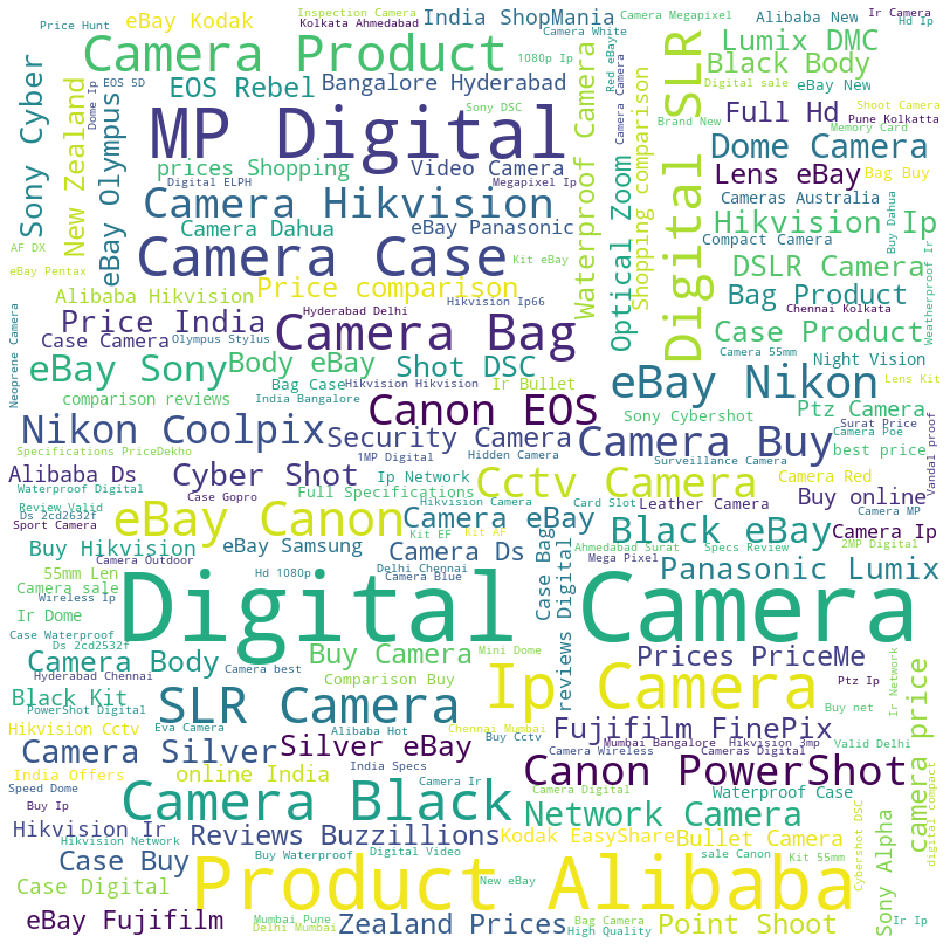

In [75]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white').generate(huge_string) 
  
# plot the WordCloud image                        
plt.figure(figsize = (13, 13), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Observations:
* SLR, Digital SLR, SLR Camera, Digital Camera, can be replaced with one word combination
* The word "Camera" carries no meaning - all items are cameras in the database
* Except we have camera Bags here? Interesting
* The words "Product", "Price", "Ebay", and other words present only on some sites and on all ads of these sites carry no meaning
* Mumbai? Zealand? India? Delphi? Weird stuff

In [76]:
def draw_wc(texts):
    huge_string = '\n'.join(texts)
    wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white').generate(huge_string) 
  
    plt.figure(figsize = (13, 13), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

%load_ext autoreload
%autoreload 2

In [82]:
from sigmod_src.data.make_dataset import preprocess_page_title

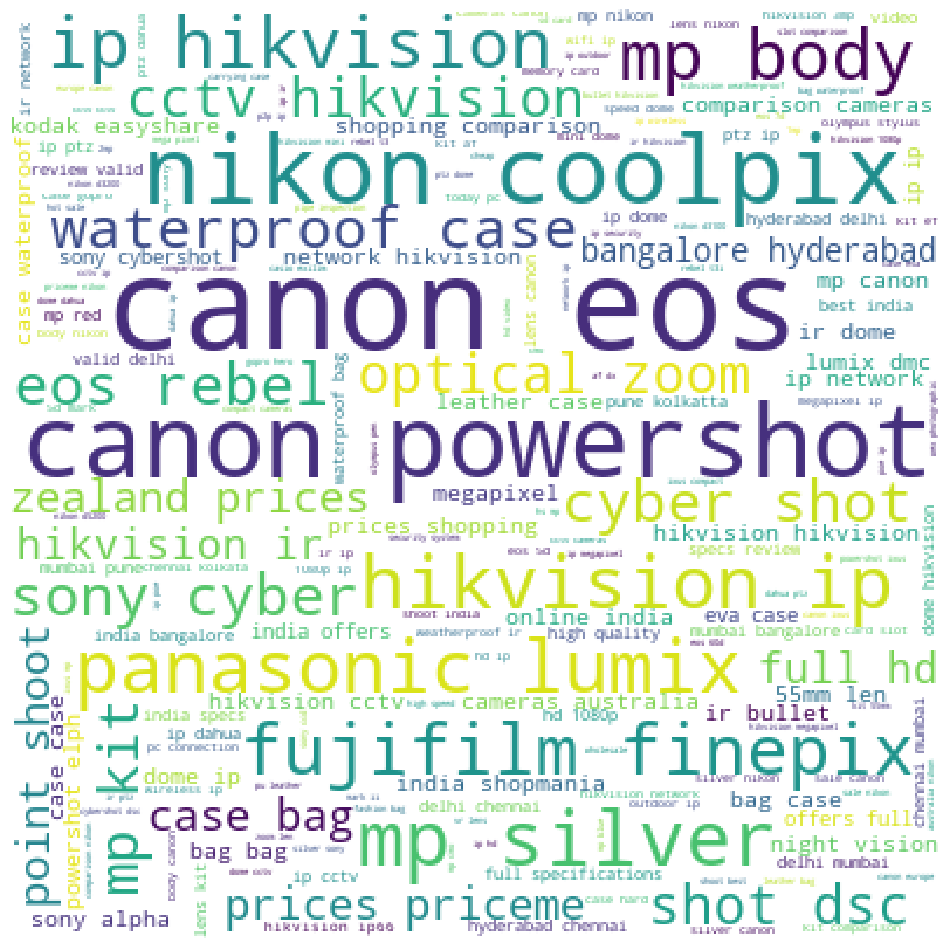

In [84]:
clean_titles = specs_df.page_title.apply(preprocess_page_title)

draw_wc(clean_titles)

### Wordcloud for all text

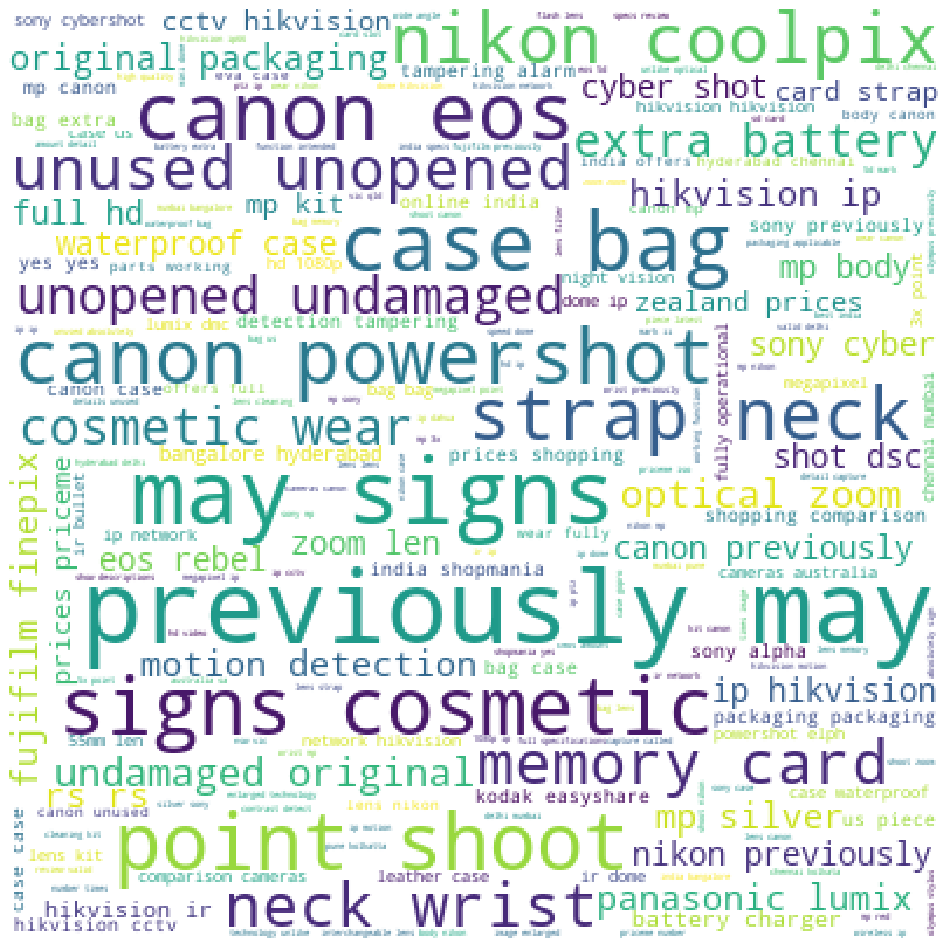

In [85]:
clean_all_text = specs_df.all_text.apply(preprocess_page_title)

draw_wc(clean_all_text)

In [87]:
from collections import Counter

In [104]:
word_counts = Counter()
for phrase in tqdm(clean_all_text):
    for word in set(phrase.split()):
        word_counts[word] += 1

HBox(children=(IntProgress(value=0, max=29787), HTML(value='')))

In [105]:
len(word_counts)

12883

In [107]:
cutoff = 3
len({k: v for k, v in word_counts.items() if v > cutoff})

4344

# Camera brands

In [91]:
major_camera_brands = ['vivitar', 'visiontek', 'vageeswari', 'traveler', 'thomson',
                       'tevion', 'sony', 'sigma', 'samsung', 'rollei', 'ricoh', 'praktica', 
                       'polaroid', 'phase one', 'pentax', 'panasonic', 'olympus', 'nikon',
                       'minox', 'memoto', 'medion', 'lytro', 'leica', 'kodak', 'hp',
                       'hasselblad', 'gopro', 'genius', 'ge', 'fujifilm', 'foscam', 
                       'epson', 'casio', 'canon', 'blackmagic design',
                       'benq', 'bell & howell', 'aigo', 'agfaphoto', 'advert tech',
                       
                       'dahua', 'philips', 'fuji', 'sanyo', 'vizio', 'sharp',
                       'logitech', 'hikvision', 'bell', 'topixo', 'magnavox'
                      ]


In [92]:
def extract_brand(page_title):
    for brand in major_camera_brands:
        if brand in page_title.lower():
            return brand
    return None

specs_df['brand'] = specs_df.page_title.str.replace("Cannon", 'Canon').apply(extract_brand)
specs_df.head()

,spec_id,site,page_title,brand
0,www.ebay.com//57656,www.ebay.com,Canon PowerShot ELPH 110 HS 16 1 MP Digital Ca...,canon
1,www.ebay.com//60583,www.ebay.com,Canon Rebel 2000 35 mm Camera Great Condition ...,canon
2,www.ebay.com//60440,www.ebay.com,Canon EOS Rebel T3i Digital SLR Camera 18 55mm...,canon
3,www.ebay.com//24139,www.ebay.com,"GE C1033 10 1 MP Digital Camera 3X Zoom 2 4"" L...",ge
4,www.ebay.com//54903,www.ebay.com,Vivitar Clip Shot Digital Camera 1 1 MP | eBay,vivitar


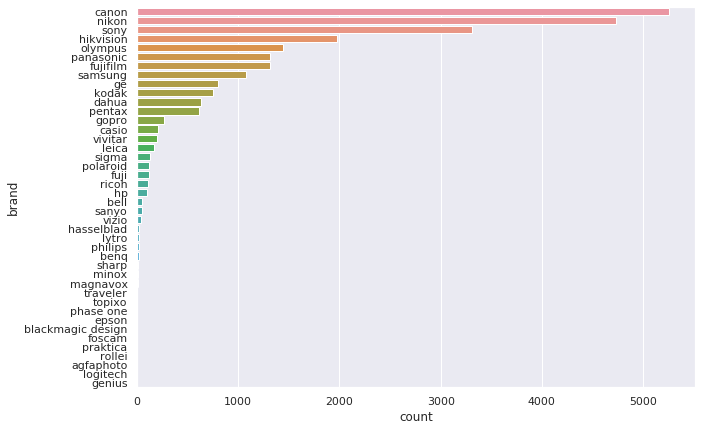

In [93]:
plt.figure()
sns.countplot(y='brand', data=specs_df, order=specs_df.brand.value_counts().index)
plt.show()

Unknown brands

In [98]:
null_brand = specs_df[specs_df.brand.isnull()]
null_brand.sample(15)

,spec_id,site,page_title,brand
19714,www.flipkart.com//2324,www.flipkart.com,Buy Lowepro Transit Backpack 350 AW Camera Bag...,None
21679,www.alibaba.com//22805,www.alibaba.com,1.0 Mp Cmos 720p Dome Ahd Analog Cctv Camera S...,None
2016,www.ebay.com//47538,www.ebay.com,Jumbl | eBay,None
27658,www.alibaba.com//29041,www.alibaba.com,"Joylemarry 720p(1280*720p)pixels @30fps,Avi Di...",None
18663,buy.net//6474,buy.net,"Sakar IS326BLK Black Digital Camera (16.1 MP, ...",None
20346,www.alibaba.com//22708,www.alibaba.com,Universal Eva Custom Digital Camera Bag Case F...,None
22046,www.alibaba.com//37579,www.alibaba.com,Croco Fashion Camera Case - Buy Digital Camera...,None
20572,www.alibaba.com//7218,www.alibaba.com,Onvif Network 1.3megapixel Camera Ip Security ...,None
22742,www.alibaba.com//37017,www.alibaba.com,Fix Dome Plastic Case Ip Surveillance Camera W...,None
22594,www.alibaba.com//25039,www.alibaba.com,2014 New Technology 2 Megapixel 1080p Hd Cvi C...,None


In [99]:
null_brand.shape

(4917, 4)

Thats a lot of nulls!

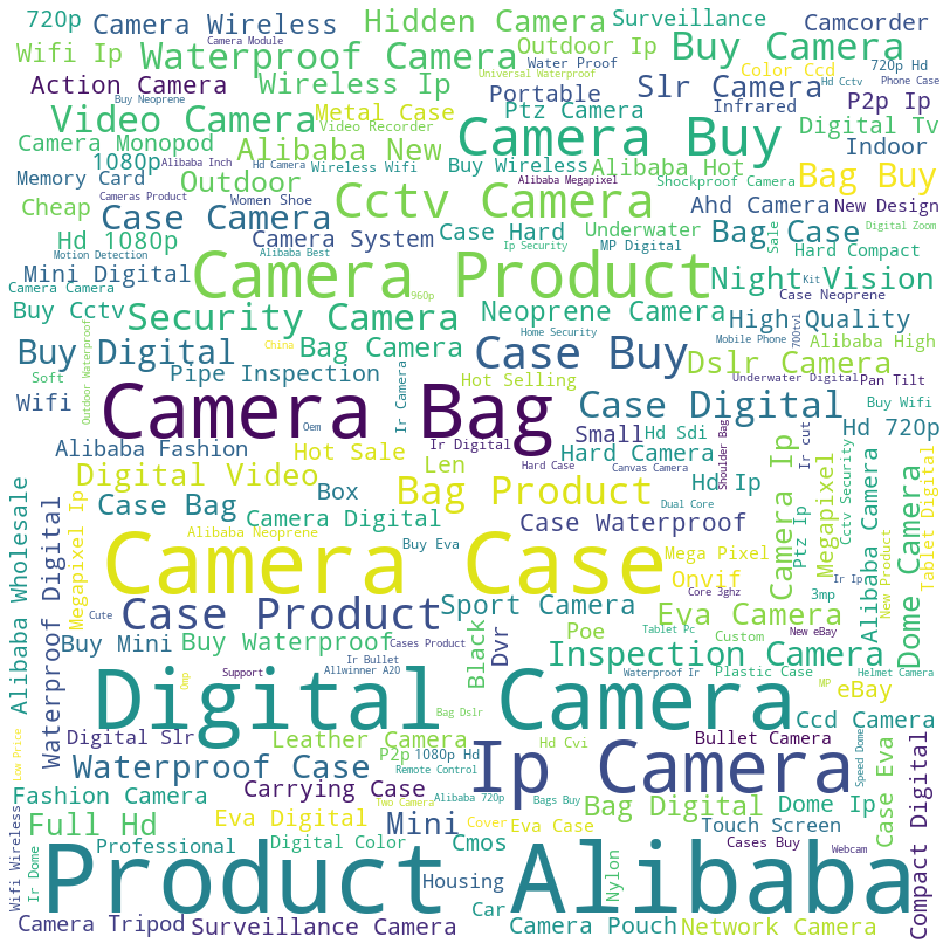

In [100]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white').generate(' '.join(null_brand.page_title.values))
  
plt.figure(figsize = (13, 13), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Effect of different preprocessings

In [48]:
import string
printable = set(string.printable)

In [35]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/boris/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [83]:
from nltk.corpus import stopwords 

In [65]:
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
stop = set(stopwords.words('english')) 

In [81]:
snow = nltk.stem.SnowballStemmer('english')

In [107]:
page_title = specs_df.page_title.sample(1).values[0]

print('1. Source page title\n', page_title)
only_printable = ' '.join([w for w in page_title.split(' ') if not w in printable])
print('2. Only printable\n', only_printable)
stemmed = ' '.join([snow.stem(word) for word in page_title.split(' ')])
print ('3. Stemmed\n', stemmed)

count_vectorizer = CountVectorizer(ngram_range=(1, 2),
    min_df=0, max_df=999999999999)
vector = count_vectorizer.fit_transform([page_title,
                                        only_printable,
                                         stemmed
                                        ])

print('\nVectorized')
pd.DataFrame(vector.todense(), columns=count_vectorizer.get_feature_names())

1. Source page title
 Nikon D5100 Digital SLR Camera | eBay
2. Only printable
 Nikon D5100 Digital SLR Camera eBay
3. Stemmed
 nikon d5100 digit slr camera | ebay

Vectorized


,camera,camera ebay,d5100,d5100 digit,d5100 digital,digit,digit slr,digital,digital slr,ebay,nikon,nikon d5100,slr,slr camera
0,1,1,1,0,1,0,0,1,1,1,1,1,1,1
1,1,1,1,0,1,0,0,1,1,1,1,1,1,1
2,1,1,1,1,0,1,1,0,0,1,1,1,1,1


## Stopwords check

In [152]:
count_vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=2)

In [180]:
count_vectorizer.fit(specs_df.page_title)
print(len(count_vectorizer.stop_words_))
list(count_vectorizer.stop_words_)[:30]

6359


['dp42849',
 's4252',
 '017852365843',
 '0074101401486',
 'fp2',
 '1749',
 '16409856',
 'fd51',
 '2600mm',
 '027242862432',
 'tvled1611',
 '241165',
 '0846951003901',
 '352',
 'atn201t',
 'shippings',
 'dscw510',
 '91029',
 '0037988985197',
 '840d',
 '885170047563',
 'f56',
 '18208261079',
 '041771483869',
 'hf3500',
 '25460',
 'hvcam',
 '5249',
 'candid',
 'gc200zkaxac']

In [183]:
specs_df.page_title[specs_df.page_title.apply(lambda x: x.lower()).str.contains('dp42849')].values[0]

'Sanyo DP42849 42" 1080i HD LCD Television 086483073489 | eBay'

In [167]:
count_vectorizer.get_feature_names()[:30]

['00',
 '000',
 '00018208099887',
 '0001820825507',
 '0009322239006',
 '001',
 '0013803001983',
 '0013803005912',
 '0013803011654',
 '0013803024487',
 '0013803037685',
 '0013803043846',
 '0013803062779',
 '0013803071122',
 '0013803123067',
 '0013803132618',
 '0013803133677',
 '0013803133752',
 '0013803134667',
 '0013803134674',
 '0013803146691',
 '0018208099894',
 '0018208131808',
 '0018208250400',
 '0018208252039',
 '0018208252084',
 '0018208254545',
 '0018208255214',
 '0018208255245',
 '0018208255320']

## Should we remove all ids, or should we keep them?